# Tropical cyclone hazard for displacement risk modelling

This tutorial shows how to use the TC hazard event sets (a) and return periods (RP) maps (b).

Technical specifications.

Resolution: 150 arcsec 

**Emission scenarios considered:** SSP245, SSP370, SSP585.  
**GCMs considered:** .  
**(Future) years considered:** 1980-2018 (ERA-5) & 1995-2014 (20thcal GCM output) - 2041-2060, 2081-2100.  
**Return periods considered for flood maps:** 1, 10, 25, 50, 100, 250.   


In each folder, there is then a combination of RCP and year, and within each RCP_year folder, there is one tif file per return period for the latitude-longitude tile.

In [1]:
import os
import pandas as pd
import numpy as np

os.chdir('/cluster/project/climate/meilers/scripts/displacement/global-displacement-risk') # change back to root folder, not "~/doc"
import coastal_flood_hazard, exposure, vulnerability

Select latitude-longitude tiles for country of interest only.

First, load exposure and get lat/lon max/mins from it.  
Then load the respective flood tiles.

## Load exposure from BEM

In [2]:
from climada.entity.exposures import Exposures

In [3]:
cntry_name = 'Sri Lanka'
reg = 'IO'

In [4]:
# Load the full dataframe, without further re-aggregation / processing other than adding centroids
gdf_bem_subcomps = exposure.gdf_from_bem_subcomps(cntry_name, opt='full')
gdf_bem_subcomps.head()

,id_1x,iso3,cpx,sector,se_seismo,valhum,valfis,bd_1_floor,bd_2_floor,bd_3_floor,geometry
0,176493293,LKA,3,beds_priv,W2,0.010976,0.000061,100.0,0.0,0.0,POINT (79.96250 9.80417)
1,176493293,LKA,3,beds_priv,W1,0.067078,0.000371,100.0,0.0,0.0,POINT (79.96250 9.80417)
2,176493293,LKA,3,beds_priv,UFB4,0.378076,0.002091,100.0,0.0,0.0,POINT (79.96250 9.80417)
3,176493293,LKA,3,beds_priv,UFB2,0.152450,0.000843,100.0,0.0,0.0,POINT (79.96250 9.80417)
4,176493293,LKA,3,beds_priv,S3,0.001220,0.000007,100.0,0.0,0.0,POINT (79.96250 9.80417)


In [5]:
# filter and apply impf id
gdf_bem_subcomps = gdf_bem_subcomps[gdf_bem_subcomps.valhum>0.001] # filter out rows with basically no population
gdf_bem_subcomps["impf_TC"] = gdf_bem_subcomps.apply(lambda row: vulnerability.DICT_PAGER_TCIMPF_HAZUS[row.se_seismo], axis=1)

In [6]:
# remove for now unnecessary cols and prepare gdf for CLIMADA Exposure
gdf_bem_subcomps.rename({'valhum' : 'value'}, axis=1)
for col in ['iso3', 'sector', 'valfis', 'se_seismo']:
    gdf_bem_subcomps.pop(col)

In [7]:
gdf_bem_subcomps

,id_1x,cpx,valhum,bd_1_floor,bd_2_floor,bd_3_floor,geometry,impf_TC
0,176493293,3,0.010976,100.000,0.000,0.00,POINT (79.96250 9.80417),12
1,176493293,3,0.067078,100.000,0.000,0.00,POINT (79.96250 9.80417),10
2,176493293,3,0.378076,100.000,0.000,0.00,POINT (79.96250 9.80417),5
3,176493293,3,0.152450,100.000,0.000,0.00,POINT (79.96250 9.80417),5
4,176493293,3,0.001220,100.000,0.000,0.00,POINT (79.96250 9.80417),8
...,...,...,...,...,...,...,...,...
5680805,176617223,1,64.965931,6.665,59.695,33.64,POINT (80.54583 5.94583),4
5680806,176617223,1,7.308667,6.665,59.695,33.64,POINT (80.54583 5.94583),13
5680807,176617223,1,292.347343,6.665,59.695,33.64,POINT (80.54583 5.94583),2
5680808,176617223,1,487.244479,6.665,59.695,33.64,POINT (80.54583 5.94583),2


In [8]:
exp = Exposures(gdf_bem_subcomps)
exp.gdf.rename({'valhum': 'value'}, axis=1, inplace=True)
exp.value_unit = 'Pop. count'
exp.gdf['longitude'] = exp.gdf.geometry.x
exp.gdf['latitude'] = exp.gdf.geometry.y
exp.gdf = exp.gdf[~np.isnan(
    exp.gdf.latitude)]  # drop nan centroids
exp.gdf.head()

,id_1x,cpx,value,bd_1_floor,bd_2_floor,bd_3_floor,geometry,impf_TC,longitude,latitude
0,176493293,3,0.010976,100.0,0.0,0.0,POINT (79.96250 9.80417),12,79.9625,9.804167
1,176493293,3,0.067078,100.0,0.0,0.0,POINT (79.96250 9.80417),10,79.9625,9.804167
2,176493293,3,0.378076,100.0,0.0,0.0,POINT (79.96250 9.80417),5,79.9625,9.804167
3,176493293,3,0.152450,100.0,0.0,0.0,POINT (79.96250 9.80417),5,79.9625,9.804167
4,176493293,3,0.001220,100.0,0.0,0.0,POINT (79.96250 9.80417),8,79.9625,9.804167


In [9]:
print('Total population '+str(cntry_name)+': ' + "{:,.0f}".format(exp.gdf.value.sum()))

Total population Sri Lanka: 33,931,442


#### Get lat/lon min/max from exposure

In [10]:
lat_min, lat_max, lon_min, lon_max = exp.gdf['latitude'].min(), exp.gdf['latitude'].max(), exp.gdf['longitude'].min(), exp.gdf['longitude'].max()

In [11]:
lat_min, lat_max, lon_min, lon_max

(5.9291666724266285, 9.829166672426407, 79.66249999999896, 81.87083333333405)

## Load hazard

### a) Event set

In [12]:
from climada.util.constants import SYSTEM_DIR
from climada.hazard import TropCyclone, Hazard
hazard_dir = SYSTEM_DIR/"hazard"/"present"

In [13]:
tc_haz = TropCyclone.from_hdf5(hazard_dir.joinpath('TC_IO_0150as_MIT_H08.hdf5'))

<GeoAxesSubplot:title={'center':'TC max intensity at each point'}>

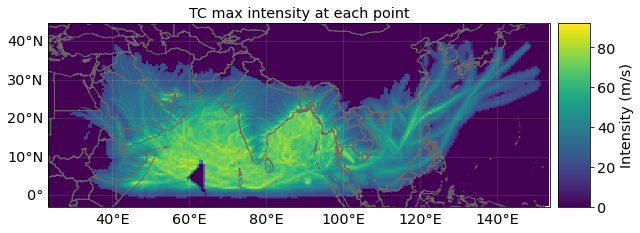

In [14]:
tc_haz.plot_intensity(event=0)

In [15]:
tc_haz_sel = tc_haz.select(extent=(lon_min, lon_max, lat_min, lat_max))

### b) Hazard maps

In [16]:
hazard_dir = SYSTEM_DIR/"hazard"/"RPmaps"

In [17]:
haz_str= f"TC_{reg}_0150as_MIT_RP-maps.nc"

In [18]:
file_path = hazard_dir.joinpath(haz_str)
print(file_path)

/cluster/work/climate/meilers/climada/data/hazard/RPmaps/TC_IO_0150as_MIT_RP-maps.nc


In [19]:
import xarray as xr
from scipy import sparse
from climada.hazard.centroids.centr import Centroids

def read_netcdf_as_hazard(file_path):
    """
    Read NetCDF file containing exceedance intensity data for various return periods
    and convert it into a Hazard object.

    Args:
    - file_path (str): Path to the NetCDF file.

    Returns:
    - Hazard: Hazard object containing the data from the NetCDF file.
    """
    with xr.open_dataset(file_path) as ds:
        centroids = Centroids(lat=ds['latitude'].values, lon=ds['longitude'].values)
        
        # Create a list to hold intensity data arrays
        intensity_arrays = []
        return_periods = [1, 10, 25, 50, 100, 250]  # Specify your return periods
        for rp in return_periods:
            intensity_var = f'intensity_RP{rp}'
            intensity_arrays.append(ds[intensity_var].values)

        # Stack arrays vertically and convert to sparse matrix
        intensity_matrix = np.vstack(intensity_arrays)
        intensity_sparse = sparse.csr_matrix(intensity_matrix)

        # Create the Hazard object
        hazard = Hazard(
            haz_type='TC',
            units='m/s',
            centroids=centroids,
            event_id=np.arange(len(np.array(return_periods, dtype=int))),
            event_name=np.arange(len(np.array(return_periods, dtype=int))),
            date=np.arange(len(np.array(return_periods, dtype=int))),
            intensity=intensity_sparse,
            frequency=1 / np.array(return_periods)
        )

    return hazard

In [20]:
RP_haz = read_netcdf_as_hazard(file_path)

<GeoAxesSubplot:title={'center':'TC max intensity at each point'}>

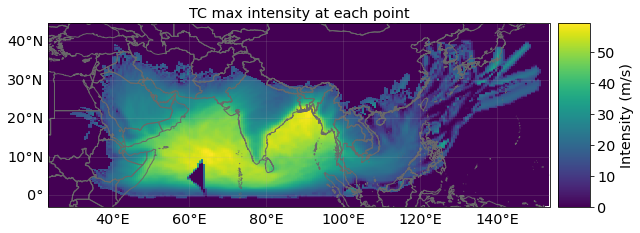

In [21]:
RP_haz.plot_intensity(event=0)

In [22]:
RP_haz_sel = RP_haz.select(extent=(lon_min, lon_max, lat_min, lat_max))

<GeoAxesSubplot:title={'center':'TC max intensity at each point'}>

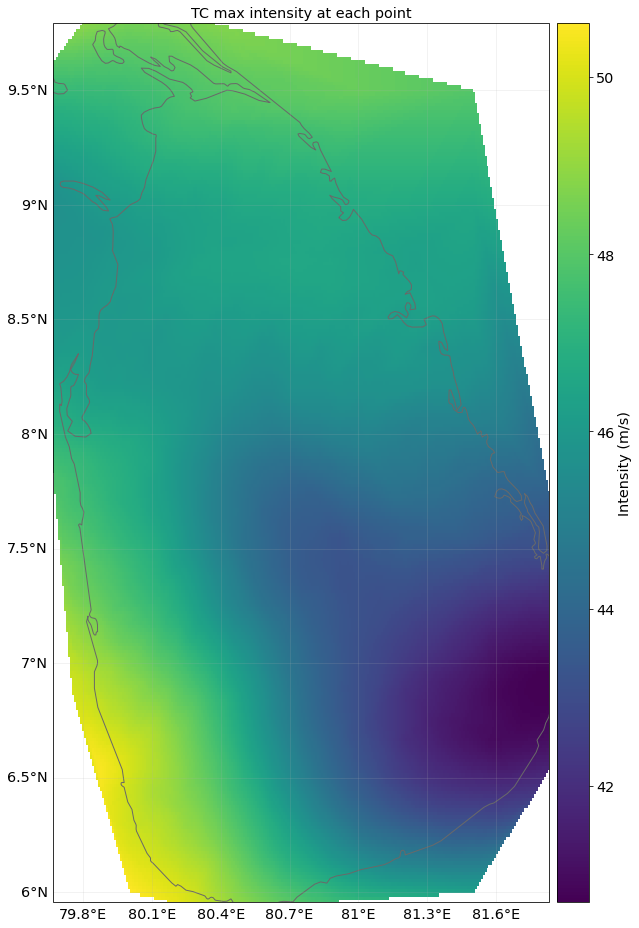

In [23]:
RP_haz_sel.plot_intensity(event=0)

## Impact functions

In [24]:
impf_set_tc = vulnerability.IMPF_SET_TC_HAZUS

In [25]:
from climada.entity import ImpactFunc, ImpactFuncSet
impf_set_tc_step = ImpactFuncSet()

In [26]:
# The threshold of building damage after which all people are displaced. Below, no-one is displaced.
building_thresh = 0.55 # 55% iDMC v1; CIMA: 30% for Somalia to 60% for other countries. 

for imp_id in impf_set_tc.get_ids(haz_type='TC'):
    impf_set_tc.get_func(fun_id=imp_id)
    y = impf_set_tc.get_func(fun_id=imp_id)[0].intensity
    x = impf_set_tc.get_func(fun_id=imp_id)[0].mdd
    thresh = np.interp(building_thresh, x, y)
    print('ID: '+str(imp_id)+' - threshold stepfunction: '+str(thresh))
    impf_set_tc_step.append(
                ImpactFunc.from_step_impf(
                    intensity=(0,  thresh, thresh *10),
                    haz_type='TC',
                    impf_id=imp_id,
                    intensity_unit = 'm/s'
                )
    )

ID: 1 - threshold stepfunction: 70.00300059923113
ID: 2 - threshold stepfunction: 94.72806709901761
ID: 3 - threshold stepfunction: 119.52032336971129
ID: 4 - threshold stepfunction: 61.7786817863342
ID: 5 - threshold stepfunction: 82.37013338804452
ID: 6 - threshold stepfunction: 102.96345988584119
ID: 7 - threshold stepfunction: 72.80330523613188
ID: 8 - threshold stepfunction: 107.080446393385
ID: 9 - threshold stepfunction: 119.52032336971129
ID: 10 - threshold stepfunction: 63.13833997892003
ID: 11 - threshold stepfunction: 72.80330523613188
ID: 12 - threshold stepfunction: 90.609506260347
ID: 13 - threshold stepfunction: 42.55683287751019
ID: 14 - threshold stepfunction: 93.38467675525862
ID: 15 - threshold stepfunction: 72.80330523613188


## Impacts

### Historical

##### a) event-based impact calculation

In [27]:
from climada.engine import ImpactCalc

impcalc = ImpactCalc(exp, impf_set_tc_step, tc_haz_sel)
impact = impcalc.impact()

In [28]:
print('Annual average displacement: ' + "{:,.0f}".format(impact.aai_agg))

Annual average displacement: 1,847


<AxesSubplot:title={'center':'Exceedance frequency curve'}, xlabel='Return period (year)', ylabel='Impact (Pop. count)'>

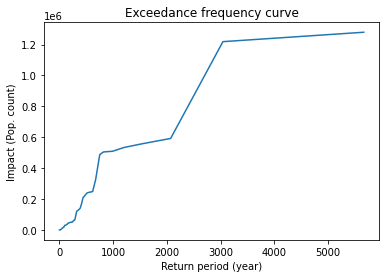

In [29]:
freq_curve = impact.calc_freq_curve()
freq_curve.plot()

<AxesSubplot:title={'center':'Exceedance frequency curve'}, xlabel='Return period (year)', ylabel='Impact (Pop. count)'>

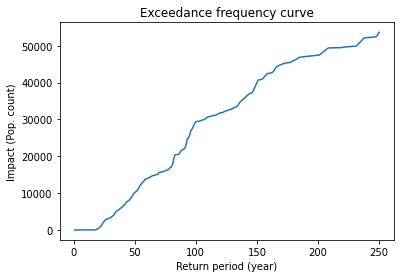

In [30]:
freq_curve = impact.calc_freq_curve(return_per=np.arange(1, 251, 1))
rp_indices = [0, 9, 24, 49, 99, 249]
pm_data = [freq_curve.impact[idx] for idx in rp_indices]
freq_curve.plot()

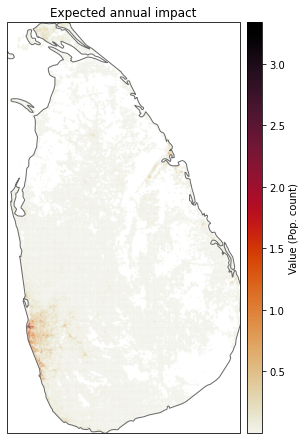

In [31]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Use the plot method and pass the GeoAxes
impact.plot_hexbin_eai_exposure(
    ignore_zero=True,
    pop_name=False,
    axis=ax
)

plt.show()

##### b) RP maps-based impact calculation

In [32]:
impcalc_RP = ImpactCalc(exp, impf_set_tc_step, RP_haz_sel)
impact_RP = impcalc_RP.impact()

In [33]:
print('Annual average displacement: ' + "{:,.0f}".format(impact_RP.aai_agg))

Annual average displacement: 473


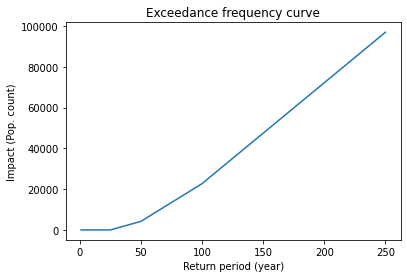

In [34]:
freq_RP_curve = impact_RP.calc_freq_curve(return_per=1/RP_haz.frequency)
freq_RP_curve.plot()
pm_RP_data = [imp for imp in freq_RP_curve.impact]

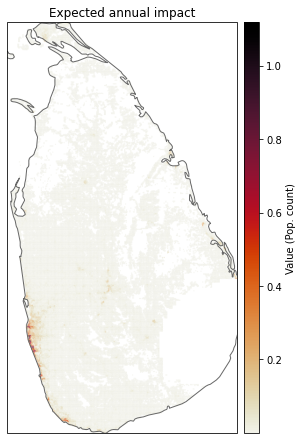

In [35]:
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})

impact_RP.plot_hexbin_eai_exposure(
    ignore_zero=True,
    pop_name=False,
    axis=ax
)

plt.show()

#### Compare results a) event-base vs. b) RP maps

In [36]:
fq_dict = {'event-based': freq_curve,
           'RP maps': freq_RP_curve}

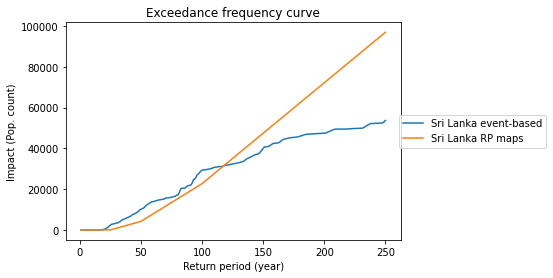

In [37]:
import matplotlib.pyplot as plt

labels = list(fq_dict.keys())

fig, axis = plt.subplots()

for i, (plots, fq) in enumerate(fq_dict.items()):
    fq.plot(axis=axis, label=str(cntry_name)+' '+labels[i])

axis.legend(loc='center right', bbox_to_anchor=(1.45, 0.5))

In [38]:
RPs = freq_RP_curve.return_per.tolist()

In [39]:
# Create the AAD DataFrame
df_AAD = pd.DataFrame({
    "event-based": [impact.aai_agg],
    "RP maps": [impact_RP.aai_agg]
}, index=["AAD"])

# Create the PMD DataFrame with 'RP' as its index
df_PMD = pd.DataFrame({
    "event-based": pm_data,
    "RP maps": pm_RP_data
}, index=["RP_" + str(int(rp)) for rp in RPs])

# Concatenate df_AAD and df_PMD vertically
df_hist = pd.concat([df_AAD, df_PMD])

# Formatting the DataFrame
df_hist_display = df_hist.style.format({
    "event-based": "{:,.0f}",
    "RP maps": "{:,.0f}"
})

df_hist_display

,event-based,RP maps
AAD,"1,847",473
RP_1,0,0
RP_10,0,0
RP_25,"2,294",0
RP_50,"10,113","4,192"
RP_100,"29,299","22,703"
RP_250,"53,688","96,985"


In [40]:
# Save the DataFrame to a CSV file
results_dir = SYSTEM_DIR/'results'
file_name = f'TC_disp_{cntry_name}_hist.csv'
df_hist.to_csv(results_dir.joinpath(file_name), index=False)

### Future

In [41]:
reg = 'IO'
models = ['cesm2', 'cnrm6', 'ecearth6', 'fgoals', 'ipsl6', 'miroc6', 'mpi6', 'mri6', 'ukmo6']
scenario = ['20thcal', 'ssp245_2cal', 'ssp585_2cal']

In [42]:
fut_haz_dict = {}
for gcm in models:
    for scen in scenario:
        haz_str_fut = f"TC_{reg}_0150as_MIT_{gcm}_{scen}_RP-maps.nc"
        file_path = hazard_dir.joinpath(haz_str_fut)
        print(file_path)
        haz = read_netcdf_as_hazard(file_path)
        haz_sel = haz.select(extent=(lon_min, lon_max, lat_min, lat_max))
        fut_haz_dict[gcm+'_'+scen] = haz_sel

/cluster/work/climate/meilers/climada/data/hazard/RPmaps/TC_IO_0150as_MIT_cesm2_20thcal_RP-maps.nc
/cluster/work/climate/meilers/climada/data/hazard/RPmaps/TC_IO_0150as_MIT_cesm2_ssp245_2cal_RP-maps.nc
/cluster/work/climate/meilers/climada/data/hazard/RPmaps/TC_IO_0150as_MIT_cesm2_ssp585_2cal_RP-maps.nc
/cluster/work/climate/meilers/climada/data/hazard/RPmaps/TC_IO_0150as_MIT_cnrm6_20thcal_RP-maps.nc
/cluster/work/climate/meilers/climada/data/hazard/RPmaps/TC_IO_0150as_MIT_cnrm6_ssp245_2cal_RP-maps.nc
/cluster/work/climate/meilers/climada/data/hazard/RPmaps/TC_IO_0150as_MIT_cnrm6_ssp585_2cal_RP-maps.nc
/cluster/work/climate/meilers/climada/data/hazard/RPmaps/TC_IO_0150as_MIT_ecearth6_20thcal_RP-maps.nc
/cluster/work/climate/meilers/climada/data/hazard/RPmaps/TC_IO_0150as_MIT_ecearth6_ssp245_2cal_RP-maps.nc
/cluster/work/climate/meilers/climada/data/hazard/RPmaps/TC_IO_0150as_MIT_ecearth6_ssp585_2cal_RP-maps.nc
/cluster/work/climate/meilers/climada/data/hazard/RPmaps/TC_IO_0150as_MIT_fg

In [43]:
impact_dict = {}
for fut, haz in fut_haz_dict.items():
    impcalc_fut = ImpactCalc(exp, impf_set_tc_step, haz)
    impact_fut = impcalc_fut.impact()
    impact_dict[fut] = impact_fut

In [44]:
aai_agg_dict = {}
pmd_dict = {}
for fut, imp in impact_dict.items():
    aai_agg_dict[fut] = imp.aai_agg
    freq_curve = imp.calc_freq_curve(return_per=1/RP_haz.frequency)
    pm_data = [fq_imp for fq_imp in freq_curve.impact]
    pmd_dict[fut] = pm_data

In [45]:
from collections import defaultdict

# Initialize a dictionary to store aggregated values by scenario
scenario_data = defaultdict(list)

# Process each item in the dictionary
for key, value in aai_agg_dict.items():
    parts = key.rsplit('_', 2)
    model = parts[0]
    scenario = parts[1]
    scenario_data[scenario].append(value)

# Calculate the mean for each scenario
scenario_means = {scenario: np.mean(values) for scenario, values in scenario_data.items()}

scenario_means

{'20thcal': 1358.0207755356817,
 'ssp245': 13709.680623050903,
 'ssp585': 54602.03779750665}

In [46]:
# Create DataFrame
data = {
    'Model': [],
    'Scenario': [],
    'Period': [],
    'AAD': []
}

for key, value in aai_agg_dict.items():
    parts = key.split('_')
    if len(parts) == 3: 
        model, scenario, period = parts
    elif len(parts) == 2: 
        model, scenario = parts
        period = "hist"
    else:
        continue

    data['Model'].append(model)
    data['Scenario'].append(scenario)
    data['Period'].append(period)
    data['AAD'].append(value)

df = pd.DataFrame(data)

# Iterate and add new columns for each RP value
for rp, rp_value in zip([1, 10, 25, 50, 100, 250], zip(*pmd_dict.values())):
    df[f'RP_{rp}'] = rp_value

df

,Model,Scenario,Period,AAD,RP_1,RP_10,RP_25,RP_50,RP_100,RP_250
0,cesm2,20thcal,hist,3776.030344,0.000000,0.000000e+00,2.897988e+04,6.719707e+04,1.609240e+05,5.049819e+05
1,cesm2,ssp245,2cal,105122.462854,291.100856,5.963612e+04,7.162837e+05,2.374886e+06,4.939096e+06,1.062953e+07
2,cesm2,ssp585,2cal,465184.406172,3056.700331,1.181252e+06,5.162207e+06,1.020635e+07,1.606437e+07,2.573820e+07
3,cnrm6,20thcal,hist,403.709523,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.614838e+04,1.009274e+05
4,cnrm6,ssp245,2cal,3004.151412,0.000000,0.000000e+00,3.883197e+04,7.688177e+04,1.215916e+05,2.299016e+05
5,cnrm6,ssp585,2cal,2061.334735,0.000000,0.000000e+00,2.403812e+03,5.116778e+04,1.242146e+05,2.462954e+05
6,ecearth6,20thcal,hist,345.117526,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.380470e+04,8.627938e+04
7,ecearth6,ssp245,2cal,2455.533791,0.000000,0.000000e+00,1.946731e+04,6.321260e+04,1.210888e+05,2.267587e+05
8,ecearth6,ssp585,2cal,5410.037292,0.000000,3.350108e+02,6.335876e+04,9.407497e+04,1.898785e+05,6.566945e+05
9,fgoals,20thcal,hist,5200.559473,0.000000,0.000000e+00,4.028573e+04,7.790796e+04,2.078383e+05,7.689430e+05


In [47]:
# Save the DataFrame to a CSV file
results_dir = SYSTEM_DIR/'results'
file_name = f'TC_disp_{cntry_name}_RP-maps.csv'
df.to_csv(results_dir.joinpath(file_name), index=False)